openapi_key를 사용 안하기위해 임베딩을 허깅페이스에 있는 bert-base-cased와 같은 여러 모델을 가지고 임베딩을 한 후 Chroma DB에 저장을 했었다



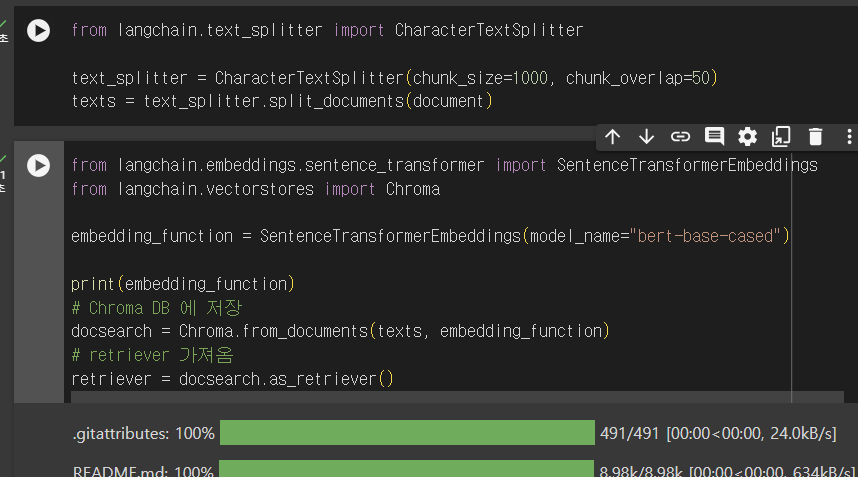




왼쪽이 허깅페이스모델로 임베딩한 결과고 오른쪽이 기존 OpenAIEmbeddings를 사용한 결과이다. 두 결과가 달라 걱정이 이만저만인 상태로 진행했다.





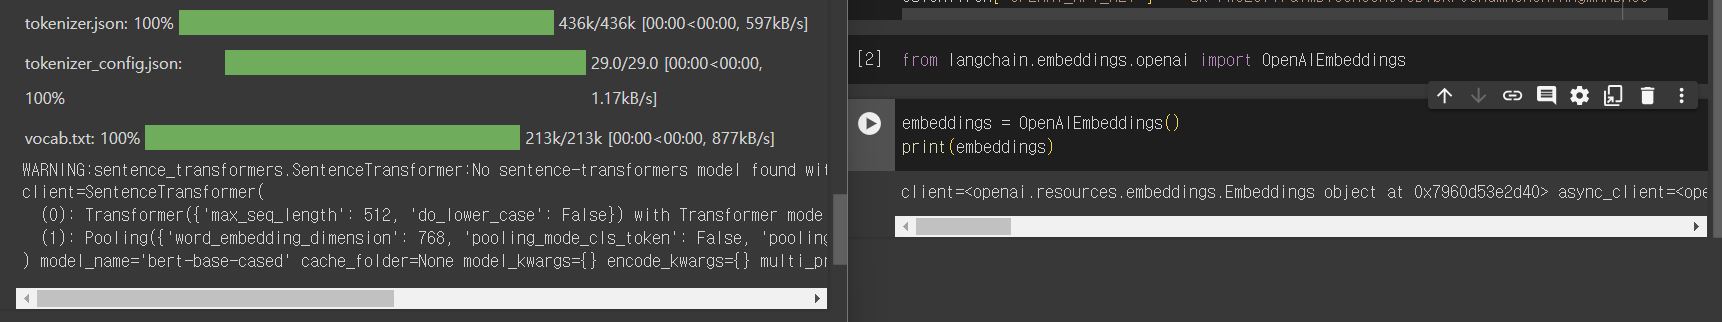





pdf의 요약과, 소설의 제목 등의 질문을 했지만 결과가 나오지 않았다. 결국 임베딩을 OpenAIEmbeddings으로 진행하기로 방향을 바꿨다.





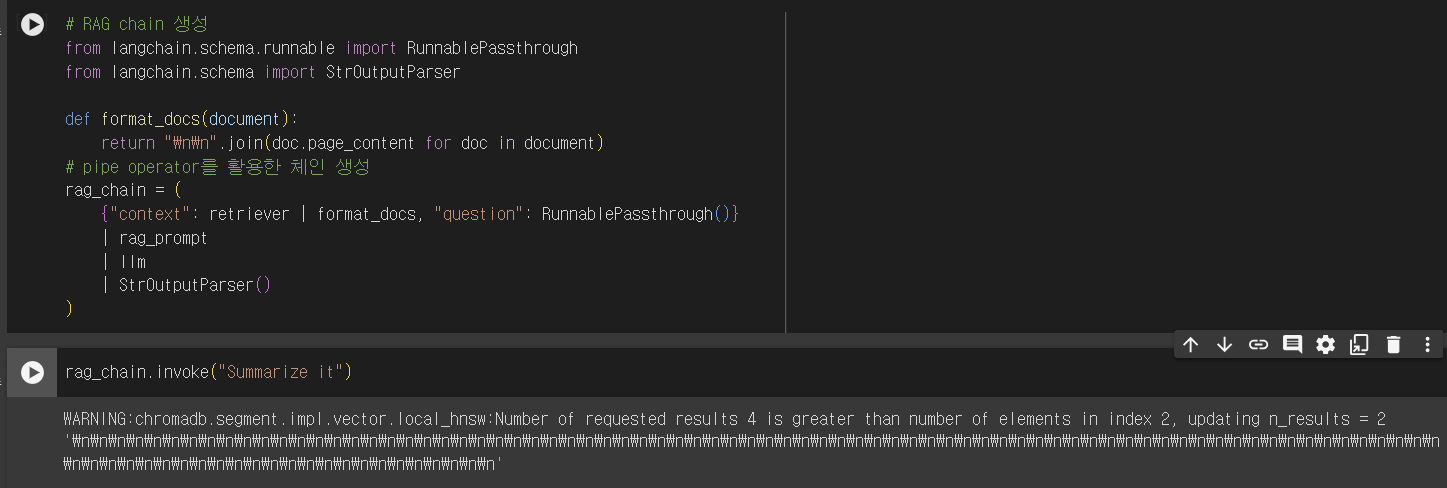

**OPENAIEMBEDDINGS 안쓰고 허깅페이스 모델 임베딩 성공!**

In [ ]:
!pip install -q langchain langchainhub pypdf

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kubernetes 28.1.0 requires urllib3<2.0,>=1.24.2, but you have urllib3 2.1.0 which is incompatible.


In [ ]:
!pip install chromadb
!pip install tiktoken

  Using cached urllib3-1.26.18-py2.py3-none-any.whl (143 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.1.0
    Uninstalling urllib3-2.1.0:
      Successfully uninstalled urllib3-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
types-requests 2.31.0.10 requires urllib3>=2, but you have urllib3 1.26.18 which is incompatible.


In [ ]:
import os

# 허깅페이스 LLM Read Key
# 이전 단계에서 복사한 Key를 아래에 붙혀넣기 합니다.
os.environ['HUGGINGFACEHUB_API_TOKEN'] = 'HUGGINGFACEHUB_API_TOKEN'

In [ ]:
!pip install python-dotenv
from dotenv import load_dotenv

# 토큰 정보로드
load_dotenv()

False

In [ ]:
from langchain.document_loaders import PyPDFLoader

# PDF 파일 로드
loader = PyPDFLoader("/content/tale.pdf")
document = loader.load()
print(document)

[Document(page_content='freshkorean. com   January 2013  \nfb.com/freshkorean   © Fresh Korean Institute  \n< 흥부와  놀부 > \n옛날 옛날에 흥부와  놀부라는  형제가  \n살았습니다 . 동생 흥부는  마음이  착했지만 , \n형 놀부는  욕심쟁이 였습니다 . 어느 추운 \n겨울날 , 갑자기  형제의  아버지가  \n돌아가시자  놀부는  갑자기  흥부의 네 \n식구를  쫓아내기로  했습니다 .  \n \n놀부: ‘ 흥! 아버지도  돌아가시고  이제 더 이상 놀부네와  같이 살 이유가  없지. \n나혼자서만  잘 살면 되지, 왜 내가 동생까지  책임져야하는거야 . 당장 쫓아내자 !’   \n \n그렇게  놀부는 흥부를 매몰차게  쫓아냈습니다 .  \n \n놀부: ‘흥부, 네 이놈! 지금 당장 짐을 싸서 이 집에서  당장 나가거라! 너희 식구들도  \n함께 나가거라 ’. ‘앋겠느냐 ?’!  \n흥부:’아이고 ! 형님, 저보고  이 추운 겨울에  식구들과  빈손으로  나가라는  \n말씀이십니까 ’?  \n놀부: ‘당연한게  아니겠느냐 ! 너한테  줄 쌀은 한 가마니도  없으니  그렇게  앋아라’. \n‘어서 나가라  이놈!’. \n \n그렇게  쫓겨난  흥부는  가족들과  비가 오면 비가 새고, 창문 사이로  바람도  쌩쌩 \n들어오는  허름한  집에서  살게 되었습니다 . 먹을 것이 없어서  흥부의  아이들은  배가 \n고파서  날마다  울었습니다 . 흥부는  형 놀부를  찾아가  먹을 것을 좀 부탁을  했지만 , \n그런 놀부는  오히려  아무것도  주지 않고 흥부를  때려서  내쫓았습니다 .  \n \n흥부: ‘형님.. 먹을 것이 없어서  제 아내와  아이들이  한달째  밥을 제대로  못 먹고 \n있습니다 . 제발.. 쌀 한 되만 주십쇼’…’형님’.. \n놀부: ‘뭐야? 그게 나랑 무슨 상관이라고 ?’ ‘너한테  줄 쌀 한톨도  없으니  썩 꺼지거라 ’. \n \n추운 겨

In [ ]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
texts = text_splitter.split_documents(document)

In [ ]:

from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="bert-base-multilingual-uncased")
# Chroma DB 에 저장
docsearch = Chroma.from_documents(texts, embeddings)
# retriever 가져옴
retriever = docsearch.as_retriever()

In [ ]:
from langchain import hub

rag_prompt = hub.pull("rlm/rag-prompt")
rag_prompt

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

In [ ]:
from langchain.llms import HuggingFaceHub

llm=HuggingFaceHub(repo_id = 'mistralai/Mistral-7B-Instruct-v0.1',
                                                      model_kwargs={"temperature": 0.1,
                                                     "max_length": 128})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: '__init__' (from 'huggingface_hub.inference_api') is deprecated and will be removed from version '1.0'. `InferenceApi` client is deprecated in favor of the more feature-complete `InferenceClient`. Check out this guide to learn how to convert your script to use it: https://huggingface.co/docs/huggingface_hub/guides/inference#legacy-inferenceapi-client.
  warnings.warn(warning_message, FutureWarning)


In [ ]:
from langchain.schema.runnable import RunnablePassthrough

# pipe operator를 활용한 체인 생성
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
)
rag_chain.invoke("이 이야기의 제목은 무엇인가요?")

' 이 이야기의 제목은 "흥부와 놀부"입니다.'

In [ ]:
rag_chain.invoke("제비의 다리를 일부러 부러뜨린 사람은 누구인가요?")

' 제비의 다리를 일부러 부러뜨린 사람은 놀부입니다.'

In [ ]:
rag_chain.invoke("제비의 다리를 고쳐준 사람은 누구인가요?")

' 제비의 다리를 고쳐준 사람은 흥부입니다.'